# Sample "imperfectly" standardized multivariate normal distribution using Cholesky decomposition.

In [1]:
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
from jax.lax import cond
from jax.scipy.stats import multivariate_normal
import numpyro
from numpyro.infer import NUTS, MCMC
from numpyro.distributions import Uniform, Normal
import numpy as np
import matplotlib.pyplot as plt
from emcee.autocorr import integrated_time
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

## Prior, likelihood, and posterior formulation

We use a uniform prior over parameters $\mathbf{x}$. The likelihood is a multivariate Gaussian,

\begin{equation}
    p(\boldsymbol{\mu}, \boldsymbol{\Sigma}|\mathbf{x}) = \frac{1}{\sqrt{\text{det}(2\pi\boldsymbol{\Sigma})}}\;\text{exp}\bigg[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\text{T}\,\boldsymbol{\Sigma}^{-1}\,(\mathbf{x}-\boldsymbol{\mu})\bigg]\;.
\end{equation}

In [2]:
# parameter bounds
ndim = 8
x_mins = jnp.array([-10.] * ndim)
x_maxs = jnp.array([10.] * ndim)

# moments of normal distribution
x_mean = jr.uniform(jr.key(0), (ndim,), minval=x_mins/2., maxval=x_maxs/2.)
normal = jr.normal(jr.key(1), (ndim,))
x_cov = jnp.outer(normal, normal) + jnp.eye(ndim) * 0.1

# parameter labels
x_labels = np.array([rf'$x_{{{i}}}$' for i in range(ndim)])

# uniform prior
def lnprior(x):
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_lnprior = jit(lnprior)

In [3]:
# likelihood
def lnlike(x):
    return multivariate_normal.logpdf(x, x_mean, x_cov)
fast_lnlike = jit(lnlike)

In [4]:
# posterior
def lnpost(x):
    return fast_lnprior(x) + fast_lnlike(x)
fast_lnpost = jit(lnpost)
vectorized_lnpost = jit(vmap(fast_lnpost))

## Sample with HMC using NUTS

In [5]:
def sampling_model():
    x = jnp.array([numpyro.sample(x_label, Uniform(x_min, x_max))
                   for x_label, x_min, x_max in zip(x_labels, x_mins, x_maxs)])
    numpyro.factor('log_likelihood', fast_lnlike(x))

In [6]:
# do HMC with NUTS
num_samples = int(1e5)
num_warmup = 1000

nuts_kernel = NUTS(sampling_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jr.key(1))
samples_dict = mcmc.get_samples()

# convert dictionary of samples to array
HMC_samples = np.array([samples_dict[x_label] for x_label in x_labels]).T

sample: 100%|██████████| 101000/101000 [00:27<00:00, 3666.71it/s, 15 steps of size 1.89e-01. acc. prob=0.91]


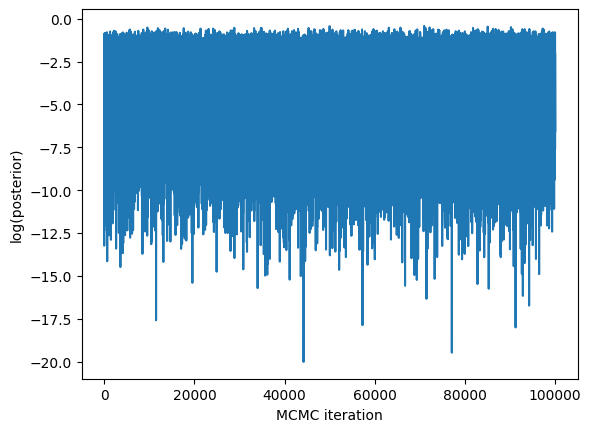

In [7]:
# plot likelihood values
HMC_lnposts = vectorized_lnpost(HMC_samples)
plt.plot(HMC_lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.show()

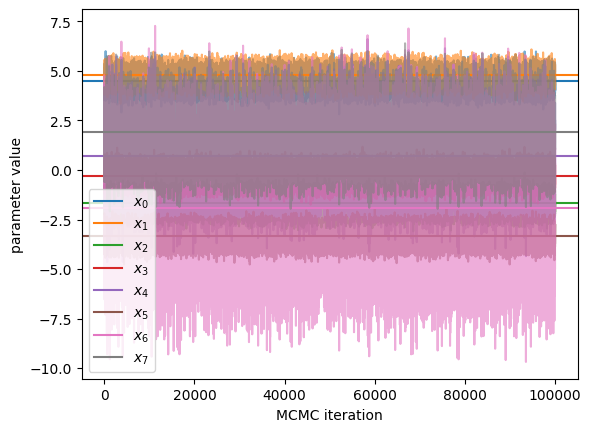

In [8]:
# trace plot
for i in range(ndim):
    plt.plot(HMC_samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(x_mean[i], color=f'C{i}', label=x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

In [9]:
auto_correlation = integrated_time(HMC_samples)[0]
print(f'auto-correlation = {auto_correlation}')

auto-correlation = 2.572970087860085


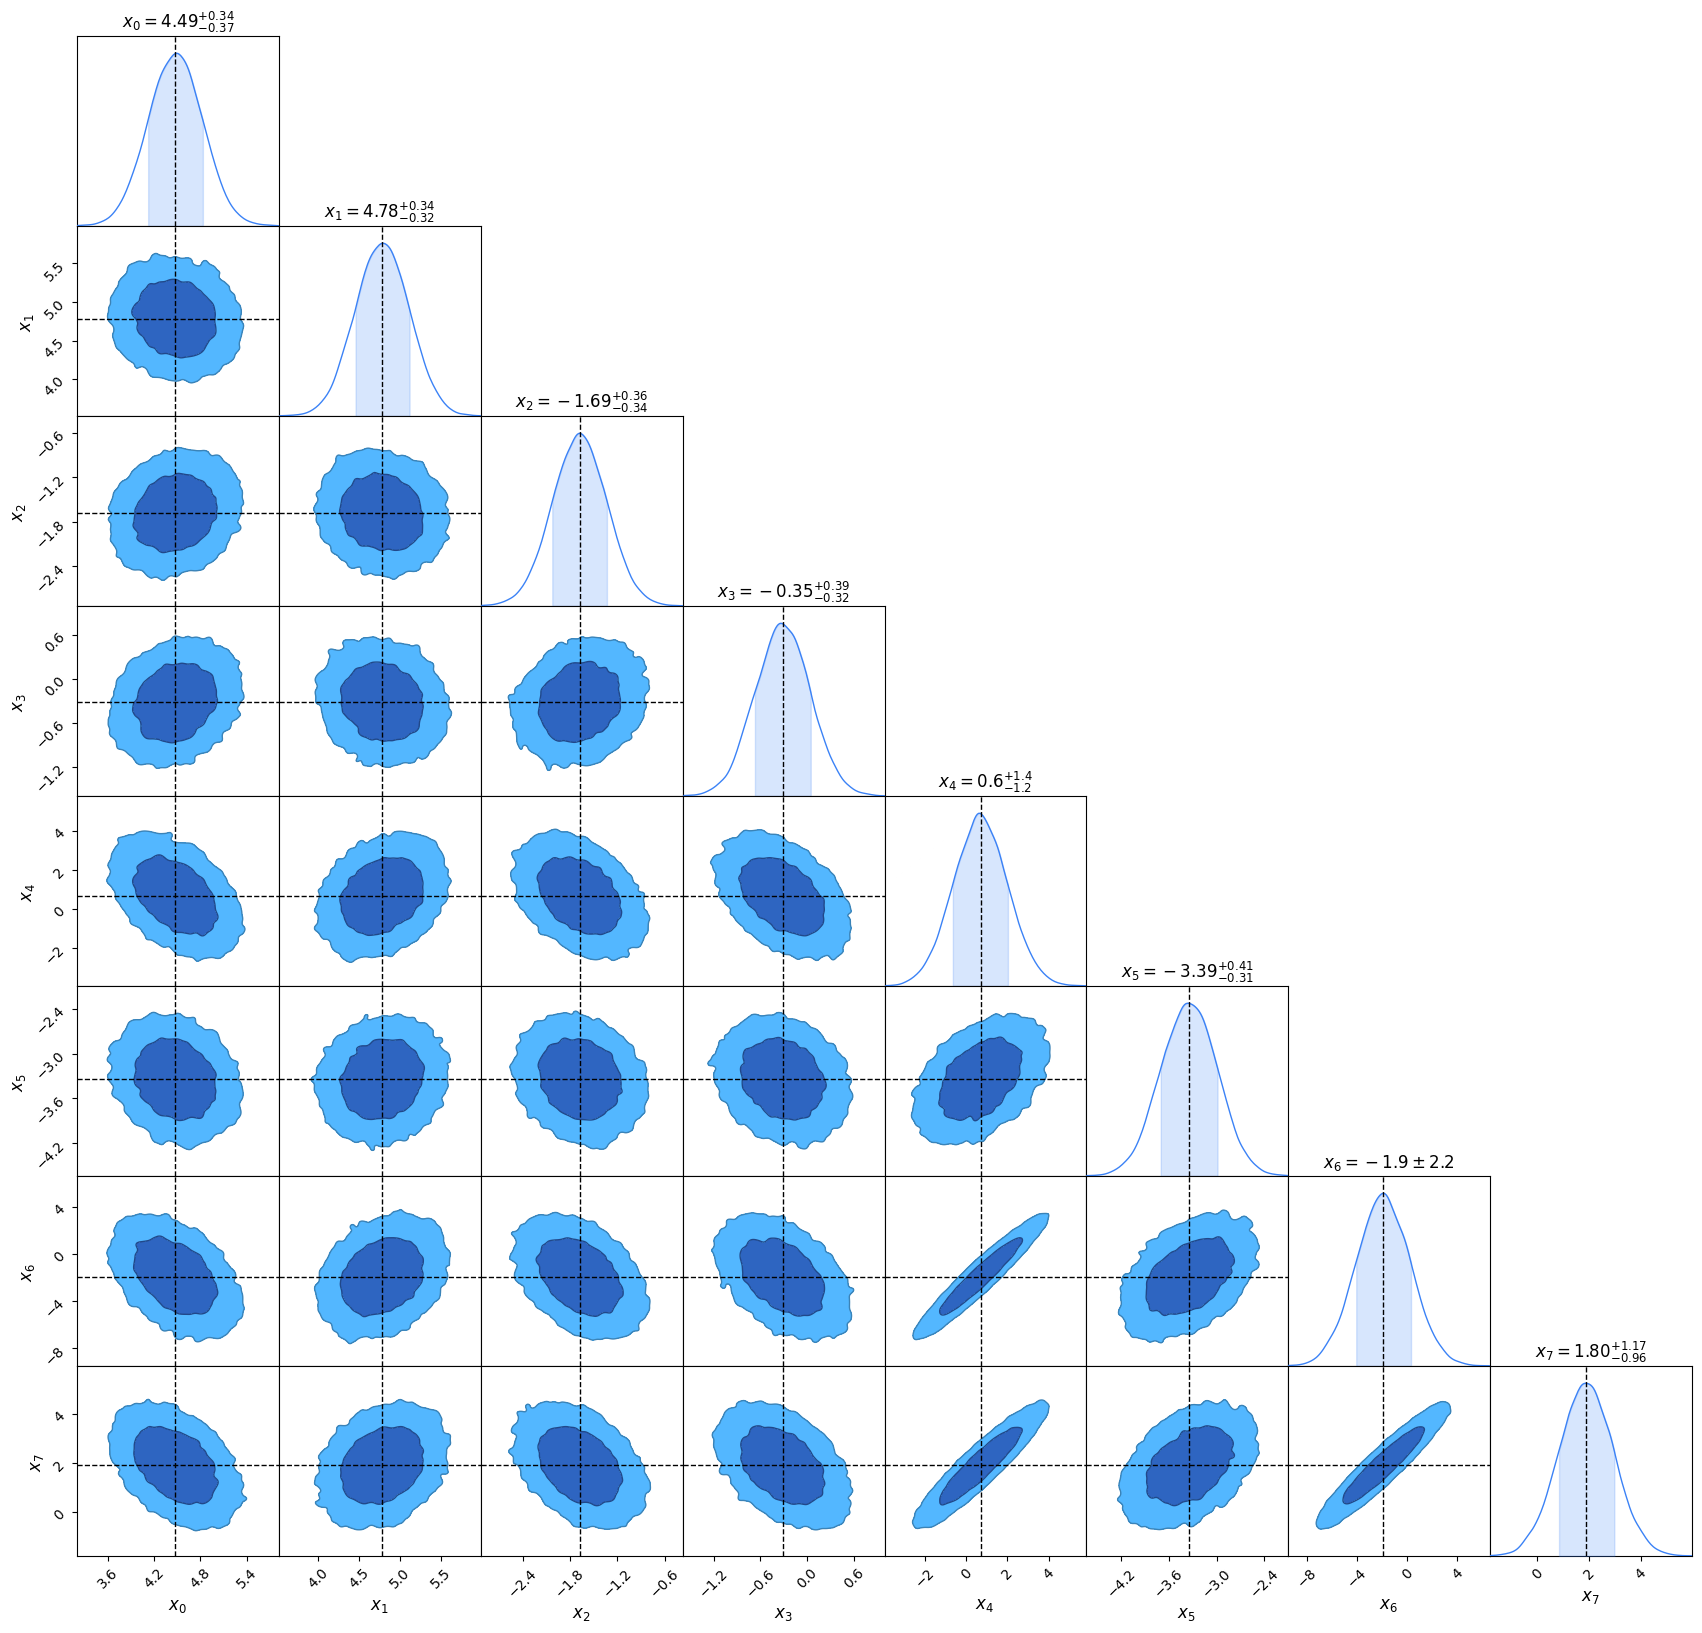

In [10]:
# plot posterior
burnin = num_samples // 10
df = pd.DataFrame(HMC_samples[burnin::(int(auto_correlation) + 1)], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_mean)}))
fig = c.plotter.plot()

## Sample from standardized distribution

We sample $\mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ then de-center and correlate these samples using the known covariance matrix. The transformed samples are then input to the posterior density.

In [11]:
# do Cholesky decomposition of covariance matrix
L = jnp.linalg.cholesky(x_cov, upper=False)

def standard_sampling_model():
    
    # sample standard normal distribution
    z = numpyro.sample('z', Normal(loc=jnp.zeros(ndim), scale=jnp.ones(ndim)))
    
    # deterministic mapping to correlated, de-centered coordinates
    x = x_mean + L @ z
    numpyro.deterministic('x', x)
    
    # evaluate posterior, subtracting off log(pdf) of standard normal
    numpyro.factor('log_posterior', fast_lnpost(x) + 0.5 * jnp.sum(z**2.))

In [12]:
# sample with HMC
num_samples = int(1e5)
num_warmup = 1000

nuts_kernel_standard = NUTS(standard_sampling_model)
mcmc = MCMC(nuts_kernel_standard, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jr.key(0))
standard_samples = mcmc.get_samples()
standard_samples = standard_samples['x']

sample: 100%|██████████| 101000/101000 [00:14<00:00, 6752.17it/s, 7 steps of size 7.37e-01. acc. prob=0.89]


In [13]:
standard_auto_correlation = integrated_time(standard_samples)[0]
print(f'un-standard auto-correlation = {auto_correlation}')
print(f'standard auto-correlation = {standard_auto_correlation}')

un-standard auto-correlation = 2.572970087860085
standard auto-correlation = 0.58325285743922


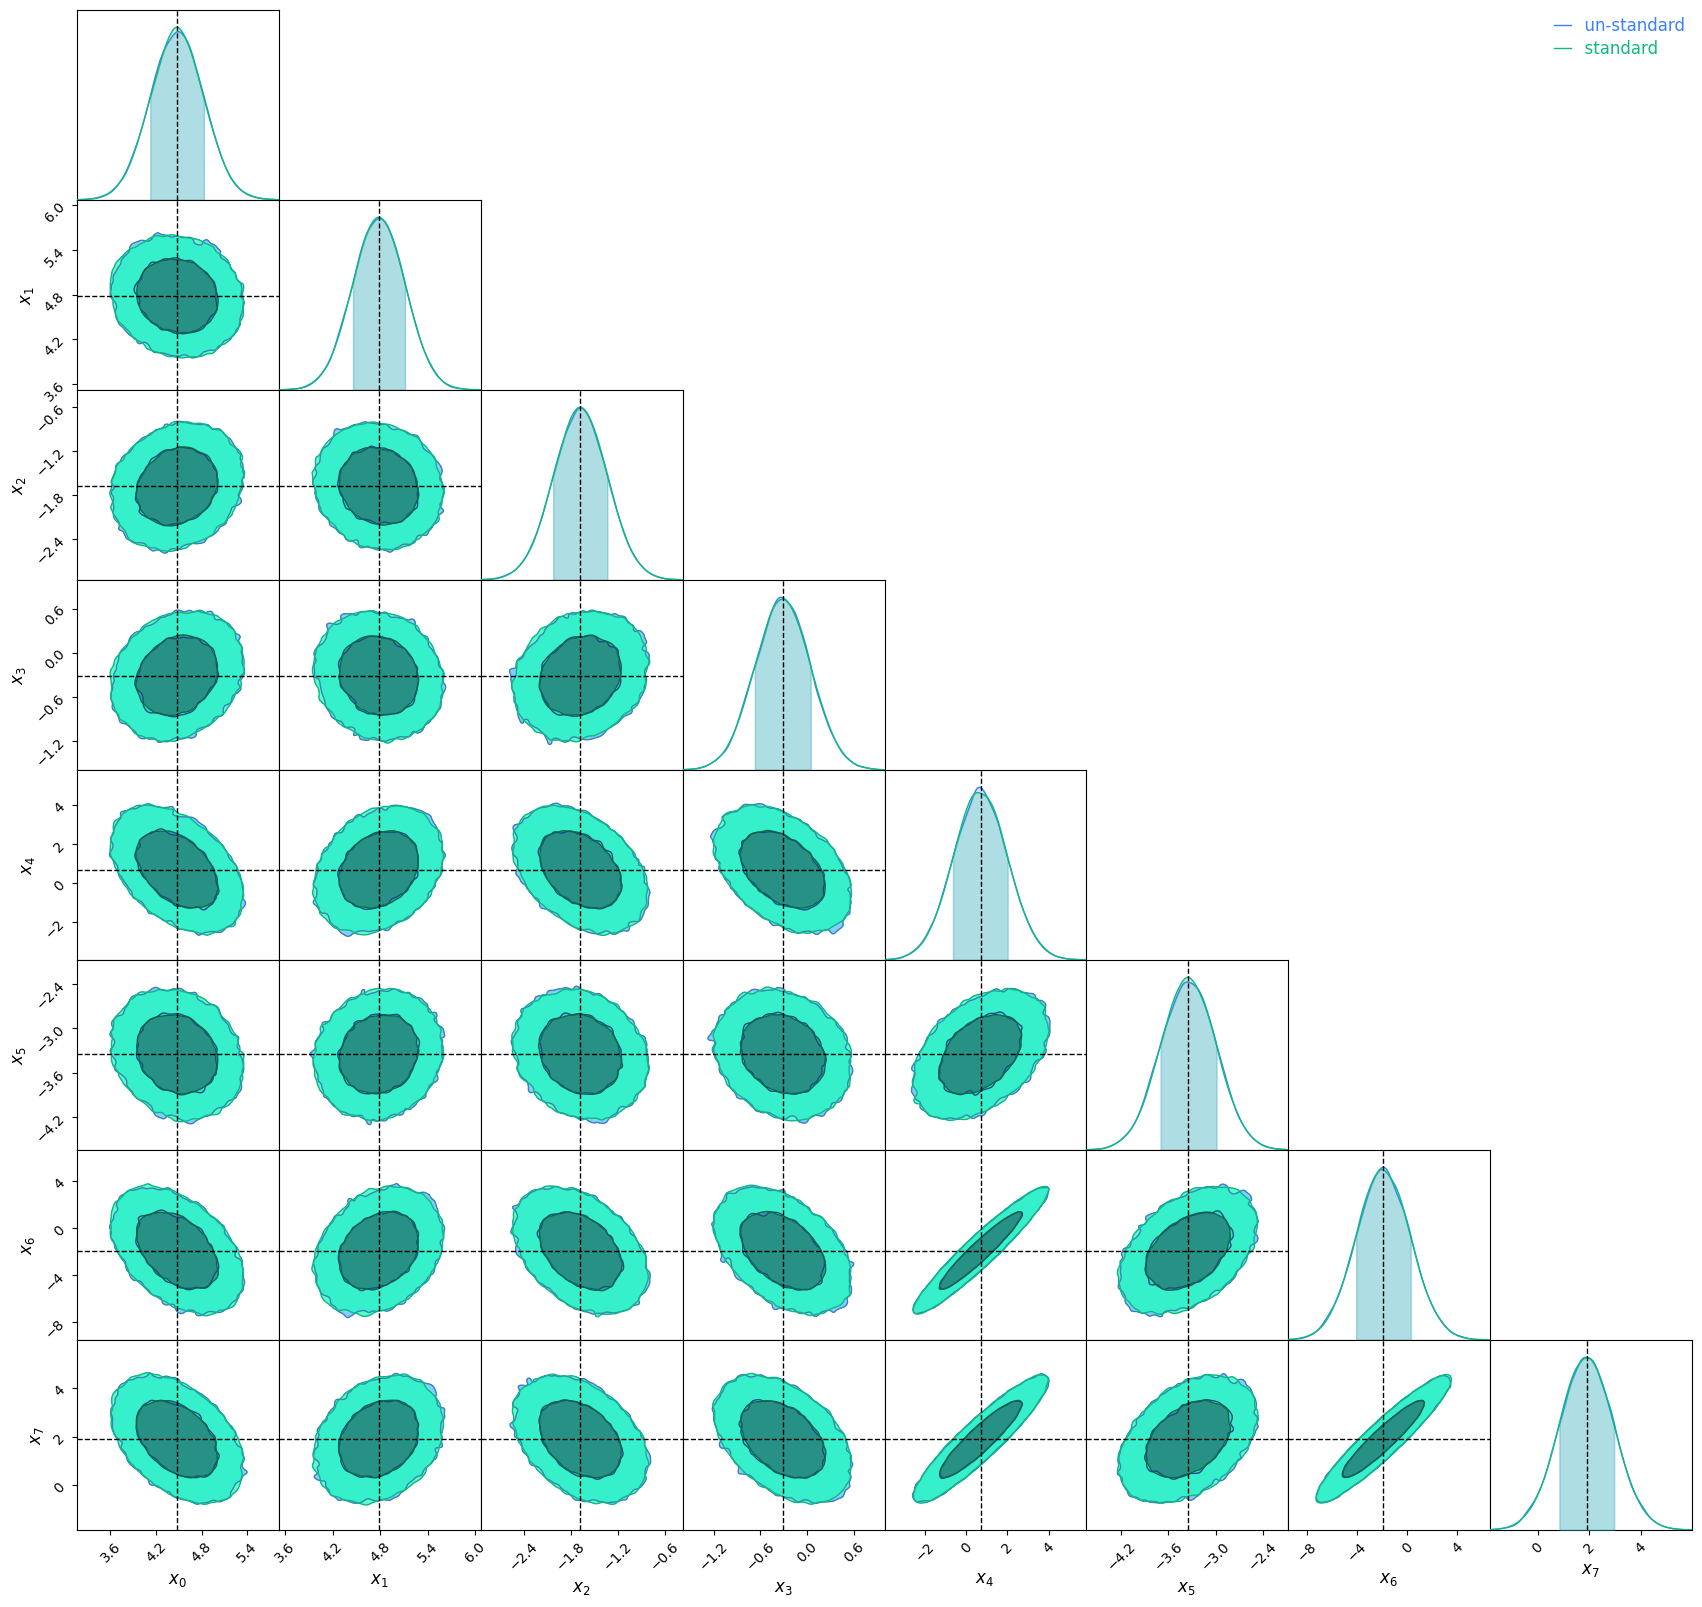

In [24]:
# plot distributions
burnin = num_samples // 10
df_standard = pd.DataFrame(standard_samples[burnin::(int(standard_auto_correlation) + 1)], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='un-standard'))
c.add_chain(Chain(samples=df_standard, name='standard'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_mean)}))
fig = c.plotter.plot()

## Imperfect standardization

Rather than using the exact mean and covariance to standardize our sampling, we vary the transformation at each iteration.

In [ ]:
# use only the diagonal of the covariance matrix in Cholesky
L_imperfect = jnp.linalg.cholesky(jnp.diag(jnp.diag(x_cov)))

# offset means by small perturbation
x_mean_imperfect = x_mean + jr.normal(jr.key(0), x_mean.shape) * 0.1

def imperfect_standard_sampling_model():
    
    # sample standard normal distribution
    z = numpyro.sample('z', Normal(loc=jnp.zeros(ndim), scale=jnp.ones(ndim)))
    
    # deterministic mapping to correlated, de-centered coordinates
    x = x_mean_imperfect + L_imperfect @ z
    numpyro.deterministic('x', x)
    
    # evaluate posterior, subtracting off log(pdf) of standard normal
    numpyro.factor('log_posterior', fast_lnpost(x) + 0.5 * jnp.sum(z**2.))

In [21]:
# sample with HMC
num_samples = int(1e5)
num_warmup = 1000

nuts_kernel_imperfect = NUTS(imperfect_standard_sampling_model)
mcmc = MCMC(nuts_kernel_imperfect, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jr.key(0))
imperfect_samples = mcmc.get_samples()
imperfect_samples = imperfect_samples['x']

sample: 100%|██████████| 101000/101000 [00:21<00:00, 4766.42it/s, 31 steps of size 1.81e-01. acc. prob=0.93]


In [23]:
imperfect_auto_correlation = integrated_time(imperfect_samples)[0]
print(f'un-standard auto-correlation = {auto_correlation}')
print(f'standard auto-correlation = {standard_auto_correlation}')
print(f'imperfect auto-correlation = {imperfect_auto_correlation}')

un-standard auto-correlation = 2.572970087860085
standard auto-correlation = 0.58325285743922
imperfect auto-correlation = 2.175148146921856


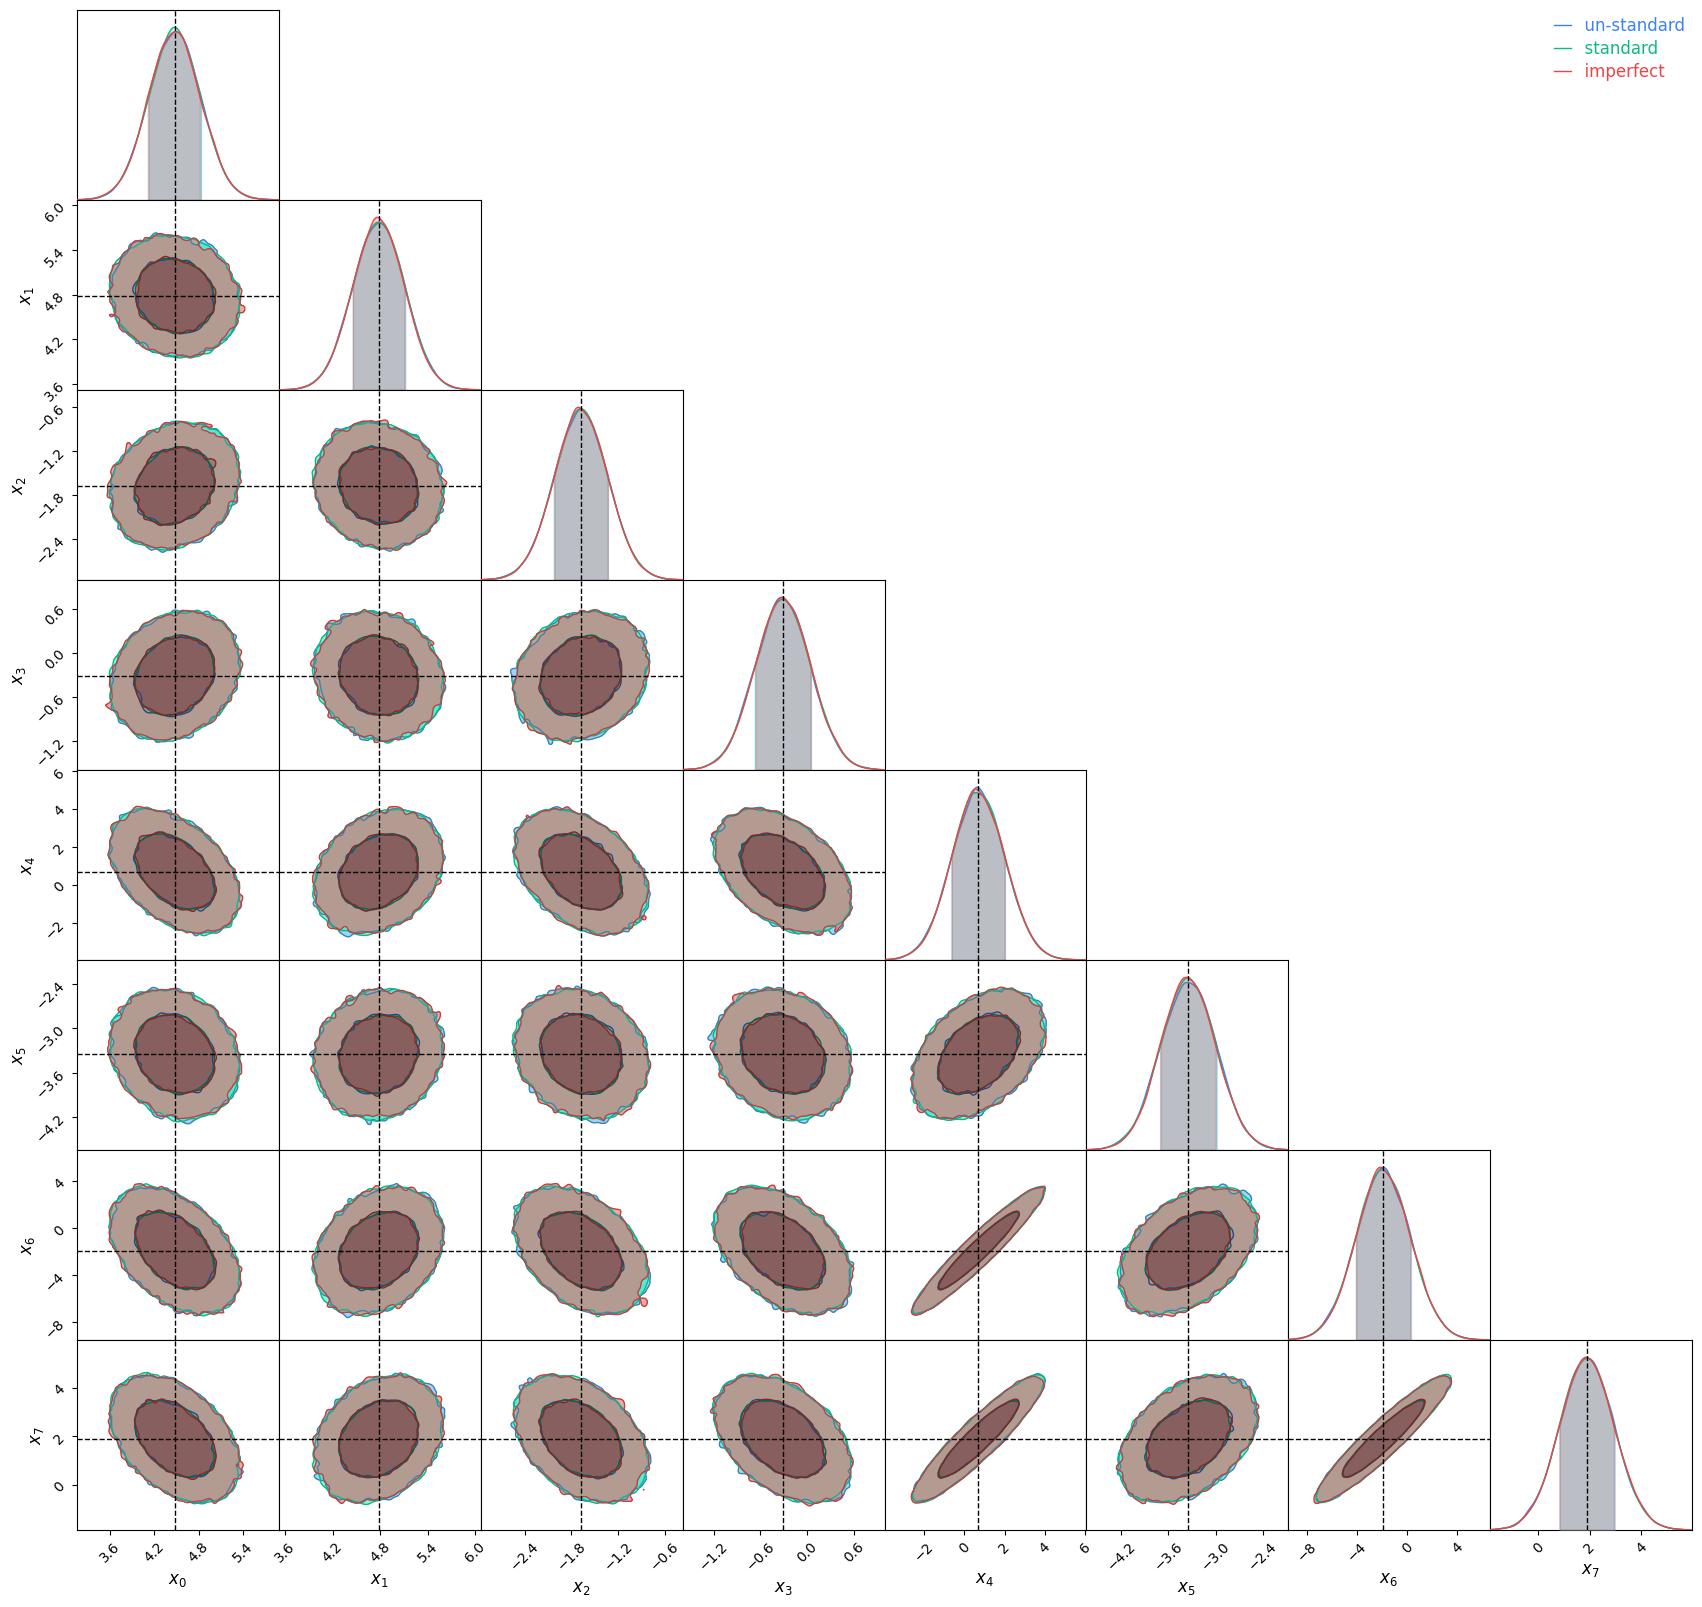

In [25]:
# plot distributions
burnin = num_samples // 10
df_imperfect = pd.DataFrame(imperfect_samples[burnin::(int(imperfect_auto_correlation) + 1)], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='un-standard'))
c.add_chain(Chain(samples=df_standard, name='standard'))
c.add_chain(Chain(samples=df_imperfect, name='imperfect'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_mean)}))
fig = c.plotter.plot()